In [14]:
import os
import wfdb
import numpy as np
import random
import sklearn
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler


def load_mitbih_dataset(path):
    # Define annotation list
    annots_list = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']
    annots_5_class = {'N': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0, 'A':0, 'a':1, 'J':1, 'S':1, 'V':2, 'E':2, 'F':3, 'f':3, '/':4, 'Q':4}

    normal = []
    # This will hold the signal segments corresponding to beats
    X = []
    # This will hold the binary labels corresponding to each beat
    y = []

    # Get the list of record names from the 'RECORDS' file
    record_list = []
    with open(os.path.join(path, 'RECORDS'), 'r') as file:
        record_list = [line.strip() for line in file]

    scaler = MinMaxScaler(feature_range=(0, 1))

    # Process each record
    for record_name in record_list:
        # Load the record and its annotation
        record = wfdb.rdrecord(os.path.join(path, record_name))
        annotation = wfdb.rdann(os.path.join(path, record_name), 'atr')

        # Get the signal and annotation values
        signal = record.p_signal[:, 0]  # assuming you only want the first signal
        beat_annotations = annotation.symbol
        beat_locations = annotation.sample

        # Iterate over each beat annotation
        for sym, loc in zip(beat_annotations, beat_locations):
            # Check if the annotation symbol is in the classes of interest
            if sym in annots_list:
                # 5-class classification
                label = annots_5_class[sym]
                
                # Define a window size around each beat
                win_size = 625  # This gives a window of 1250 samples around the beat
                # Avoid going out of bounds
                if loc - win_size >= 0 and loc + win_size <= len(signal):
                    segment = signal[loc - win_size: loc + win_size]
                    segment = scaler.fit_transform(segment.reshape(-1, 1)).flatten()
                    # if (label==0):
                    #     normal.append((segment, label))
                    # else:
                    X.append(segment)
                    y.append(label)

    # for elem in random.sample(normal, (len(normal))//2):
    #     X.append(elem[0])
    #     y.append(elem[1])

    # Convert lists to numpy arrays for ML processing
    X = np.array(X)
    y = to_categorical(y, num_classes=5)

    return X, y


In [4]:
def reshape_data_2D(X):
    # Reshape data from 1D to 2D format 
    num_samples = X.shape[0]
    X_reshaped = X.reshape(num_samples, 25, 50, 1)
    return X_reshaped

In [18]:
def reshape_data_1D(X):
    # Reshape data from 2D to 1D format 
    num_samples = X.shape[0]
    X_reshaped = X.reshape(num_samples, 1250, 1)
    return X_reshaped

In [38]:
#run this step just onceeeeeeeeee, next time just load from the saved train test
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

X, y = load_mitbih_dataset("/home/anishar5/anisha/Research-Work/mit-bih-dataset")

# Convert one-hot encoded labels back to single integer labels
y_int = np.argmax(y, axis=1)

# Split the data into training and test sets
X_train, X_test, y_train_int, y_test_int = train_test_split(X, y_int, test_size=0.20, random_state=42, stratify=y_int)

# Apply SMOTE to the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res_int = smote.fit_resample(X_train, y_train)
#X_train_res = reshape_data_2D(X_train_res)
#X_test = reshape_data_2D(X_test)

# Convert resampled integer labels back to one-hot encoding
y_train_res = to_categorical(y_train_res_int, num_classes=5)

# Convert test integer labels to one-hot encoding
y_test = to_categorical(y_test_int, num_classes=5)

In [39]:
from collections import Counter

y_train_list = y_train_int.tolist()
y_train_res_list = y_train_res_int.tolist()

print(f'Original class distribution: {Counter(y_train_list)}')
print(f'Class distribution after SMOTE: {Counter(y_train_res_list)}')

print(f'Test class distribution: {Counter(y_test_int.tolist())}')

Original class distribution: Counter({0: 74398, 2: 5782, 4: 5634, 3: 1427, 1: 188})
Class distribution after SMOTE: Counter({0: 188, 1: 188, 2: 188, 3: 188, 4: 188})
Test class distribution: Counter({0: 18600, 2: 1445, 4: 1409, 3: 357, 1: 47})


In [20]:
# Step 1: Perform the split once

# Step 2: Save the split data to disk
np.save('./X_train_AS.npy', X_train_res)
np.save('./X_test_AS.npy', X_test)
np.save('./y_train_AS.npy', y_train_res)
np.save('./y_test_AS.npy', y_test)

# In future sessions, you can load the datasets directly from the saved files:
X_train = np.load('./X_train_AS.npy')
X_test = np.load('./X_test_AS.npy')
y_train = np.load('./y_train_AS.npy')
y_test = np.load('./y_test_AS.npy')

# Use X_train, X_test, y_train, y_test for model training and evaluations

In [25]:
!ls -l *.npy


-rw-rw-r-- 1 anishar5 anishar5  218580128 Jul 19 15:28 X_test_BS.npy
-rw-rw-r-- 1 anishar5 anishar5  125580128 Jul 19 14:11 X_test_DS.npy
-rw-rw-r-- 1 anishar5 anishar5  218580128 Jul 22 16:19 X_test_ENN.npy
-rw-rw-r-- 1 anishar5 anishar5  218580128 Jul  5 16:29 X_test_SMOTE.npy
-rw-rw-r-- 1 anishar5 anishar5 3719900128 Jul 19 15:28 X_train_BS.npy
-rw-rw-r-- 1 anishar5 anishar5 1859950128 Jul 19 14:11 X_train_DS.npy
-rw-rw-r-- 1 anishar5 anishar5 3664230128 Jul 22 16:19 X_train_ENN.npy
-rw-r--r-- 1 anishar5 anishar5 3719900128 Jul  5 16:29 X_train_SMOTE.npy
-rw-rw-r-- 1 anishar5 anishar5     437288 Jul 19 15:28 y_test_BS.npy
-rw-rw-r-- 1 anishar5 anishar5     251288 Jul 19 14:11 y_test_DS.npy
-rw-rw-r-- 1 anishar5 anishar5     437288 Jul 22 16:19 y_test_ENN.npy
-rw-rw-r-- 1 anishar5 anishar5     437288 Jul  5 16:29 y_test_SMOTE.npy
-rw-rw-r-- 1 anishar5 anishar5    7439928 Jul 19 15:28 y_train_BS.npy
-rw-rw-r-- 1 anishar5 anishar5    3720028 Jul 19 14:11 y_train_DS.npy
-rw-rw-r-- 1 ani

In [5]:
# Loading the Saved Train-Test Split
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, TimeDistributed, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc

# Load the saved datasets
X_train = np.load('./X_train_BS.npy')
X_test = np.load('./X_test_BS.npy')
y_train = np.load('./y_train_BS.npy')
y_test = np.load('./y_test_BS.npy')

X_train = reshape_data_2D(X_train)
X_test = reshape_data_2D(X_test)

In [41]:
print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)

(21858, 25, 50, 1)
(21858, 5)
(371990, 25, 50, 1)
(371990, 5)


In [5]:
#Defining my Model
#network.py
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, TimeDistributed, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_lstm_model(input_shape=(1250, 1)):
    # No need to pass num_classes for binary classification
    inputs = keras.layers.Input(shape=input_shape)

    # Convolutional layers
    x11 = Conv1D(filters=3, kernel_size=31, strides=5, padding='same', activation=None, use_bias=True)(inputs)
    x12 = Conv1D(filters=3, kernel_size=36, strides=5, padding='same', activation=None, use_bias=True)(inputs)
    x13 = Conv1D(filters=3, kernel_size=41, strides=5, padding='same', activation=None, use_bias=True)(inputs)
    conv = keras.layers.concatenate([x11, x12, x13], axis=-1)

    # Batch normalization and ReLU activation
    x = BatchNormalization()(conv)
    x = ReLU()(x)

    # LSTM layer
    x = TimeDistributed(Flatten())(x)
    x = LSTM(200, return_sequences=False)(x)  # Adjust return_sequences based on whether you're adding more LSTM layers or not

    # Dense layers for classification
    x = Dropout(0.3)(x)
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(10, activation='relu')(x)
    
    # Adjusted for binary classification: single output neuron, sigmoid activation
    outputs = Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=[outputs], name="lstm_model")
    
    # Compile the model with binary crossentropy loss and include 'Precision' and 'Recall' in metrics
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall'])

    return model


In [18]:
from tensorflow.keras import layers, models, regularizers, optimizers

def load_2D_CNN(input_shape=(25, 50, 1)):

    # Hyperparameters from the paper
    learning_rate = 3e-3
    momentum = 0.7
    regularization_param = 0.2

    # Define the Sequential model
    model = models.Sequential()

    # Layer 0–1: Convolutional Layer
    model.add(layers.Conv2D(
        filters=258, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        activation=None,  # Activation added separately to specify LeakyReLU
        input_shape=input_shape,  
        kernel_regularizer=regularizers.l2(regularization_param)
    ))
    model.add(layers.LeakyReLU(alpha=0.01))  # Adding LeakyReLU activation

    # Layer 1–2: Max-Pooling Layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 2–3: Convolutional Layer
    model.add(layers.Conv2D(
        filters=129*5, 
        kernel_size=(2, 2), 
        strides=(1, 1), 
        activation=None,
        kernel_regularizer=regularizers.l2(regularization_param)
    ))
    model.add(layers.LeakyReLU(alpha=0.01))

    # Layer 3–4: Max-Pooling Layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 4–5: Convolutional Layer
    model.add(layers.Conv2D(
        filters=126, 
        kernel_size=(4, 4), 
        strides=(1, 1), 
        activation=None,
        kernel_regularizer=regularizers.l2(regularization_param)
    ))
    model.add(layers.LeakyReLU(alpha=0.01))

    # Layer 5–6: Max-Pooling Layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output before fully connected layers
    model.add(layers.Flatten())

    # Layer 6–7: Fully-Connected Layer
    model.add(layers.Dense(30, activation='linear', kernel_regularizer=regularizers.l2(regularization_param)))
    model.add(layers.LeakyReLU(alpha=0.01))

    # Layer 7–8: Fully-Connected Layer
    model.add(layers.Dense(20, activation='linear', kernel_regularizer=regularizers.l2(regularization_param)))
    model.add(layers.LeakyReLU(alpha=0.01))

    # Layer 8–9: Fully-Connected Layer (Output Layer)
    model.add(layers.Dense(5, activation='softmax'))  # Assuming a classification problem with 5 classes

    # Compile the model
    model.compile(
        optimizer=optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
        loss='categorical_crossentropy', 
        metrics=['accuracy','Precision', 'Recall']
    )
    return model

x = load_2D_CNN()
x.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 conv2d_18 (Conv2D)          (None, 23, 48, 258)       2580      
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 23, 48, 258)       0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 11, 24, 258)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 10, 23, 645)       666285    
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 10, 23, 645)       0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 5, 11, 645)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 2, 8, 126)         1300446   
          

In [17]:
from tensorflow.keras import layers, models, regularizers, optimizers

def load_simplified_2D_CNN(input_shape=(25, 50, 1)):
    # Hyperparameters from the paper
    learning_rate = 3e-3
    momentum = 0.7
    regularization_param = 0.1

    # Define the Sequential model
    model = models.Sequential()

    # Layer 0–1: Convolutional Layer
    model.add(layers.Conv2D(
        filters=64, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        activation=None, 
        input_shape=input_shape,  
        kernel_regularizer=regularizers.l2(regularization_param)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    # Layer 1–2: Max-Pooling Layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 2–3: Convolutional Layer
    model.add(layers.Conv2D(
        filters=128, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        activation=None,
        kernel_regularizer=regularizers.l2(regularization_param)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    # Layer 3–4: Max-Pooling Layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 4–5: Convolutional Layer
    model.add(layers.Conv2D(
        filters=256, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        activation=None,
        kernel_regularizer=regularizers.l2(regularization_param)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    # Layer 5–6: Global Average Pooling Layer
    model.add(layers.GlobalAveragePooling2D())

    # Layer 6–7: Fully-Connected Layer
    model.add(layers.Dense(128, activation='linear', kernel_regularizer=regularizers.l2(regularization_param)))
    model.add(layers.LeakyReLU(alpha=0.01))

    # Layer 7–8: Fully-Connected Layer
    model.add(layers.Dense(64, activation='linear', kernel_regularizer=regularizers.l2(regularization_param)))
    model.add(layers.LeakyReLU(alpha=0.01))

    # Layer 8–9: Fully-Connected Layer (Output Layer)
    model.add(layers.Dense(5, activation='softmax'))  # Assuming a classification problem with 5 classes

    # Compile the model
    model.compile(
        optimizer=optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
        loss='categorical_crossentropy', 
        metrics=['accuracy', 'Precision', 'Recall']
    )

    return model

x = load_simplified_2D_CNN()
x.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 23, 48, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 23, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 23, 48, 64)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 11, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 9, 22, 128)        73856     
                                                                 
 batch_normalization_4 (Batc  (None, 9, 22, 128)      

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def load_1D_CNN():

    # Define the Sequential model
    model = models.Sequential()

    # Layer 1: Conv1D with 128 filters of size 50, activation ReLU, stride 3
    model.add(layers.Conv1D(
        filters=128,
        kernel_size=50,  # Kernel size adapted to input length
        strides=3,  # Stride adjusted for larger input length
        activation='relu',
        padding='same',  # Keep same padding to maintain the sequence length
        input_shape=(1250, 1)  # Updated input shape
    ))

    # Layer 2: Batch Normalization
    model.add(layers.BatchNormalization())

    # Layer 3: MaxPooling1D with pool size 2, stride 2
    model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    # Layer 4: Conv1D with 32 filters of size 7, activation ReLU, stride 1
    model.add(layers.Conv1D(
        filters=32,
        kernel_size=7,  # Smaller kernel size to capture finer details
        strides=1,
        activation='relu',
        padding='same'  # Same padding to keep the sequence length consistent
    ))

    # Layer 5: Batch Normalization
    model.add(layers.BatchNormalization())

    # Layer 6: MaxPooling1D with pool size 2, stride 2
    model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    # Layer 7: Conv1D with 32 filters of size 10, activation ReLU, stride 1
    model.add(layers.Conv1D(
        filters=32,
        kernel_size=10,  # Kernel size adapted for capturing medium range patterns
        strides=1,
        activation='relu',
        padding='same'  # Keep same padding to avoid reducing the sequence length
    ))

    # Layer 8: Conv1D with 128 filters of size 5, activation ReLU, stride 1
    model.add(layers.Conv1D(
        filters=128,
        kernel_size=5,
        strides=1,  # Reduced stride to prevent downsampling too quickly
        activation='relu',
        padding='same'  # Same padding to maintain sequence length
    ))

    # Layer 9: MaxPooling1D with pool size 2, stride 2
    model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    # Layer 10: Conv1D with 256 filters of size 15, activation ReLU, stride 1
    model.add(layers.Conv1D(
        filters=256,
        kernel_size=15,  # Larger kernel size for wider feature detection
        strides=1,
        activation='relu',
        padding='same'  # Same padding to keep the sequence length consistent
    ))

    # Layer 11: MaxPooling1D with pool size 2, stride 2
    model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    # Layer 12: Conv1D with 512 filters of size 5, activation ReLU, stride 1
    model.add(layers.Conv1D(
        filters=512,
        kernel_size=5,
        strides=1,
        activation='relu',
        padding='same'  # Same padding to avoid reducing the sequence length too much
    ))

    # Layer 13: Conv1D with 128 filters of size 3, activation ReLU, stride 1
    model.add(layers.Conv1D(
        filters=128,
        kernel_size=3,  # Small kernel size for fine details
        strides=1,
        activation='relu',
        padding='same'  # Keep same padding to avoid reducing the sequence length
    ))

    # Layer 14: Flatten layer
    model.add(layers.Flatten())

    # Layer 15: Dense layer with 512 units, activation ReLU, dropout rate 0.1
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.1))

    # Layer 16: Dense layer with softmax activation for output
    model.add(layers.Dense(5, activation='softmax'))  # Adjust the number of output classes as necessary

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



x = load_1D_CNN()
# Print the model summary
x.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 417, 128)          6528      
                                                                 
 batch_normalization (BatchN  (None, 417, 128)         512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 208, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 208, 32)           28704     
                                                                 
 batch_normalization_1 (Batc  (None, 208, 32)          128       
 hNormalization)                                                 
                                                        

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers

# Define the residual convolutional block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same', 
                      kernel_initializer=initializers.HeNormal(), 
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same', 
                      kernel_initializer=initializers.HeNormal(), 
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

# Define the model
def create_rescnn(input_shape=(1250, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # First residual block
    x = layers.Conv1D(32, kernel_size=3, strides=1, padding='same', 
                      kernel_initializer=initializers.HeNormal(), 
                      kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = residual_block(x, 32)
    x = layers.MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Second residual block
    x = residual_block(x, 32)
    x = layers.MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Third residual block
    x = residual_block(x, 32)
    x = layers.MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Flatten and add dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dense(64, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01))(x)
    outputs = layers.Dense(5, activation='softmax')(x)  # Assuming 5 classes

    model = models.Model(inputs, outputs)
    return model

# Instantiate and compile the model
input_shape = (1250, 1)  # Modify as necessary
model = create_rescnn(input_shape)

model.summary()


/home/anishar5/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1250, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1250, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1250, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 1250, 32)     0           ['batch_normalization[0][0]']

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

def CNN2D_second(input_shape=(25, 50, 1)):
    # Define the model
    model = Sequential()

    # Convolutional Block 1
    model.add(Conv2D(8, (4, 4), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # Convolutional Block 2
    model.add(Conv2D(13, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # Convolutional Block 3
    model.add(Conv2D(13, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # Flatten the output
    model.add(Flatten())

    # Dropout for regularization
    model.add(Dropout(0.5))

    # Fully Connected Layer 1
    model.add(Dense(128, activation='relu'))

    # Fully Connected Layer 2
    model.add(Dense(64, activation='relu'))

    # Output Layer
    model.add(Dense(5, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model summary
input_shape = (25, 50, 1)
model = CNN2D_second(input_shape)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 50, 8)         136       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 25, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 25, 13)        429       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 13, 13)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 13, 13)         689       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 7, 13)        

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense

def create_gcnn_model(input_shape=(25, 50, 1)):
    # Define the model
    model = Sequential()

    # Convolutional Block C1
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Convolutional Block C2
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Pooling Layer P1
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # Convolutional Block C3
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Convolutional Block C4
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Pooling Layer P2
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    # Convolutional Block C5
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    # Output Layer
    model.add(Dense(5, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Example of model compilation and summary
input_shape = (25, 50, 1)
model = create_gcnn_model(input_shape)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 50, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 25, 50, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 25, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 50, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 25, 50, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 25, 50, 32)        0

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Softmax

def load_lstm(input_shape=(25,50)):
    # Define the model
    model = Sequential()

    # Bidirectional LSTM Block
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add((LSTM(64, return_sequences=False)))

    # Dense Layers
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    # Output Layer
    model.add(Dense(5, activation='softmax'))  # Assuming 5 classes for the softmax layer

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model summary
x = load_lstm()
x.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 25, 128)          58880     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 256)               16640     
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                      

In [9]:
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense)
from tensorflow.keras.models import Model
import numpy as np


class ResidualUnit(object):
    """Residual unit block (unidimensional).
    Parameters
    ----------
    n_samples_out: int
        Number of output samples.
    n_filters_out: int
        Number of output filters.
    kernel_initializer: str, optional
        Initializer for the weights matrices. See Keras initializers. By default it uses
        'he_normal'.
    dropout_keep_prob: float [0, 1), optional
        Dropout rate used in all Dropout layers. Default is 0.8
    kernel_size: int, optional
        Kernel size for convolutional layers. Default is 17.
    preactivation: bool, optional
        When preactivation is true use full preactivation architecture proposed
        in [1]. Otherwise, use architecture proposed in the original ResNet
        paper [2]. By default it is true.
    postactivation_bn: bool, optional
        Defines if you use batch normalization before or after the activation layer (there
        seems to be some advantages in some cases:
        https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md).
        If true, the batch normalization is used before the activation
        function, otherwise the activation comes first, as it is usually done.
        By default it is false.
    activation_function: string, optional
        Keras activation function to be used. By default 'relu'.
    References
    ----------
    .. [1] K. He, X. Zhang, S. Ren, and J. Sun, "Identity Mappings in Deep Residual Networks,"
           arXiv:1603.05027 [cs], Mar. 2016. https://arxiv.org/pdf/1603.05027.pdf.
    .. [2] K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition," in 2016 IEEE Conference
           on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778. https://arxiv.org/pdf/1512.03385.pdf
    """

    def __init__(self, n_samples_out, n_filters_out, kernel_initializer='he_normal',
                 dropout_keep_prob=0.8, kernel_size=17, preactivation=True,
                 postactivation_bn=False, activation_function='relu'):
        self.n_samples_out = n_samples_out
        self.n_filters_out = n_filters_out
        self.kernel_initializer = kernel_initializer
        self.dropout_rate = 1 - dropout_keep_prob
        self.kernel_size = kernel_size
        self.preactivation = preactivation
        self.postactivation_bn = postactivation_bn
        self.activation_function = activation_function

    def _skip_connection(self, y, downsample, n_filters_in):
        """Implement skip connection."""
        # Deal with downsampling
        if downsample > 1:
            y = MaxPooling1D(downsample, strides=downsample, padding='same')(y)
        elif downsample == 1:
            y = y
        else:
            raise ValueError("Number of samples should always decrease.")
        # Deal with n_filters dimension increase
        if n_filters_in != self.n_filters_out:
            # This is one of the two alternatives presented in ResNet paper
            # Other option is to just fill the matrix with zeros.
            y = Conv1D(self.n_filters_out, 1, padding='same',
                       use_bias=False, kernel_initializer=self.kernel_initializer)(y)
        return y

    def _batch_norm_plus_activation(self, x):
        if self.postactivation_bn:
            x = Activation(self.activation_function)(x)
            x = BatchNormalization(center=False, scale=False)(x)
        else:
            x = BatchNormalization()(x)
            x = Activation(self.activation_function)(x)
        return x

    def __call__(self, inputs):
        """Residual unit."""
        x, y = inputs
        n_samples_in = y.shape[1]
        downsample = n_samples_in // self.n_samples_out
        n_filters_in = y.shape[2]
        y = self._skip_connection(y, downsample, n_filters_in)
        # 1st layer
        x = Conv1D(self.n_filters_out, self.kernel_size, padding='same',
                   use_bias=False, kernel_initializer=self.kernel_initializer)(x)
        x = self._batch_norm_plus_activation(x)
        if self.dropout_rate > 0:
            x = Dropout(self.dropout_rate)(x)

        # 2nd layer
        x = Conv1D(self.n_filters_out, self.kernel_size, strides=downsample,
                   padding='same', use_bias=False,
                   kernel_initializer=self.kernel_initializer)(x)
        if self.preactivation:
            x = Add()([x, y])  # Sum skip connection and main connection
            y = x
            x = self._batch_norm_plus_activation(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
        else:
            x = BatchNormalization()(x)
            x = Add()([x, y])  # Sum skip connection and main connection
            x = Activation(self.activation_function)(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
            y = x
        return [x, y]


def load_dnn(n_classes, input_shape, last_layer='sigmoid'):
    kernel_size = 16
    kernel_initializer = 'he_normal'
    signal = Input(shape=input_shape, dtype=np.float32, name='signal')
    x = signal
    x = Conv1D(64, kernel_size, padding='same', use_bias=False,
               kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x, y = ResidualUnit(input_shape[0] // 4, 128, kernel_size=kernel_size, kernel_initializer=kernel_initializer)([x, x])
    x, y = ResidualUnit(input_shape[0] // 16, 196, kernel_size=kernel_size, kernel_initializer=kernel_initializer)([x, y])
    x, y = ResidualUnit(input_shape[0] // 64, 256, kernel_size=kernel_size, kernel_initializer=kernel_initializer)([x, y])
    x, _ = ResidualUnit(input_shape[0] // 256, 320, kernel_size=kernel_size, kernel_initializer=kernel_initializer)([x, y])
    x = Flatten()(x)
    diagn = Dense(n_classes, activation=last_layer, kernel_initializer=kernel_initializer)(x)
    model = Model(signal, diagn)
    return model


model = load_dnn(5, (1250, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 signal (InputLayer)            [(None, 1250, 1)]    0           []                               
                                                                                                  
 conv1d_14 (Conv1D)             (None, 1250, 64)     1024        ['signal[0][0]']                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 1250, 64)    256         ['conv1d_14[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 1250, 64)     0           ['batch_normalization_4[0][0]

In [14]:
import os
import re

# Path to the directory where checkpoints are saved
checkpoint_dir = './model_checkpoint.keras'

# List all files in the checkpoint directory
checkpoint_files = os.listdir(checkpoint_dir)

# Regular expression to extract the epoch number from the filename
epoch_regex = r"_epoch_(\d+)_"

# Initialize a list to store the epoch numbers
epochs = []

# Iterate over the checkpoint filenames
for filename in checkpoint_files:
    match = re.search(epoch_regex, filename)
    if match:
        # Extract the epoch number and convert it to an integer
        epoch_num = int(match.group(1))
        epochs.append(epoch_num)

# Find the maximum epoch number (last saved epoch)
if epochs:
    last_saved_epoch = max(epochs)
    print(f"The last saved epoch was: {last_saved_epoch}")
else:
    print("No checkpoints found.")


NotADirectoryError: [Errno 20] Not a directory: './model_checkpoint.keras'

In [69]:
#Compiling and Training the Model
import os
from tensorflow import keras

# Calculate class weights for balancing the training
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weight_dict = dict(enumerate(class_weights))

# Check if a checkpoint exists
load_existing = False
checkpoint_path = './model_checkpoint.keras'
if os.path.exists(checkpoint_path) and load_existing:
    print("Loading previously saved model...")
    model = keras.models.load_model(checkpoint_path)
    # Manually set the initial_epoch parameter based on how many epochs were previously run
    initial_epoch = 13  # Adjust this based on your last saved epoch
else:
    print("No checkpoint found. Initializing a new model...")
    #model = create_lstm_model(input_shape=(1250, 1))
    #model = load_1D_CNN()
    #model = create_gcnn_model()
    #model = load_simplified_2D_CNN()
    #model = CNN2D_second()
    #model = load_dnn(5, (1250, 1))
    model = load_lstm()
    #model = create_rescnn((1250, 1))
    initial_epoch = 0

# Continue with the compilation, setup your callbacks and start training
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Consider setting this to False if you want to save after every epoch regardless of performance
    monitor='val_accuracy',
    mode='max',
    verbose=1)

print("Training model")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,  # Total number of epochs you aim to train
    initial_epoch=initial_epoch,  # Start from the epoch after the last saved one
    batch_size=32,
    callbacks=[model_checkpoint_callback],
    class_weight=class_weight_dict)

# Optionally, save the final model
final_model_path = 'final_model.keras'
model.save(final_model_path)
print(f"Model saved to {final_model_path}")
print(history.history.keys())


No checkpoint found. Initializing a new model...
Training model
Epoch 1/15
11625/11625 [==============================] - ETA: 0s - loss: 0.2665 - accuracy: 0.8960 - precision: 0.9376 - recall: 0.8677
Epoch 1: val_accuracy improved from -inf to 0.94588, saving model to ./model_checkpoint.keras
11625/11625 [==============================] - 467s 40ms/step - loss: 0.2665 - accuracy: 0.8960 - precision: 0.9376 - recall: 0.8677 - val_loss: 0.1623 - val_accuracy: 0.9459 - val_precision: 0.9491 - val_recall: 0.9435
Epoch 2/15
11625/11625 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9878 - precision: 0.9884 - recall: 0.9873
Epoch 2: val_accuracy improved from 0.94588 to 0.97543, saving model to ./model_checkpoint.keras
11625/11625 [==============================] - 463s 40ms/step - loss: 0.0412 - accuracy: 0.9878 - precision: 0.9884 - recall: 0.9873 - val_loss: 0.0930 - val_accuracy: 0.9754 - val_precision: 0.9760 - val_recall: 0.9745
Epoch 3/15
11625/11625 [=======

In [1]:
from tensorflow.keras.models import load_model

model = load_model('./model_checkpoint.keras')
#model = load_model('./dnn_final.keras')

model.summary()

/home/anishar5/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 25, 128)          58880     
 nal)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_27 (Dense)            (None, 256)               16640     
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                      

In [6]:
#Evaluating the Model on Test Data
eval_results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {eval_results[0]}")
print(f"Test Accuracy: {eval_results[1]}")


684/684 [==============================] - 12s 15ms/step - loss: 0.0589 - accuracy: 0.9880 - precision: 0.9883 - recall: 0.9878
Test Loss: 0.05892636254429817
Test Accuracy: 0.9880135655403137


In [7]:
#Generating Predictions
y_pred_probs = model.predict(X_test)
#y_pred = np.round(y_pred_probs).astype(int)  # Assuming a binary classification
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print(y_pred[:30])


684/684 [==============================] - 11s 15ms/step
[0 0 0 0 0 0 0 4 0 4 0 4 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 4]


In [8]:
#Generating and Printing the Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred, target_names=['N', 'S', 'V', 'F', 'Q']))


              precision    recall  f1-score   support

           N       1.00      0.99      0.99     18600
           S       0.68      0.40      0.51        47
           V       0.93      0.97      0.95      1445
           F       0.87      0.83      0.85       357
           Q       0.99      0.99      0.99      1409

    accuracy                           0.99     21858
   macro avg       0.89      0.84      0.86     21858
weighted avg       0.99      0.99      0.99     21858



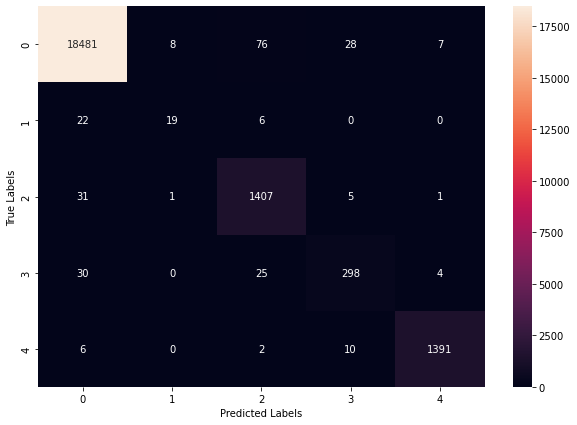

In [9]:
#Plotting the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


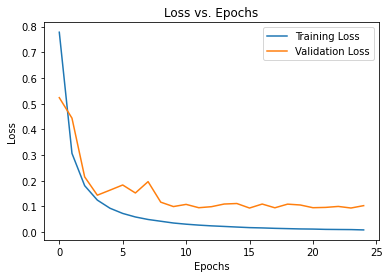

In [66]:
#Plotting Learning Curves (Loss vs Epoch)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

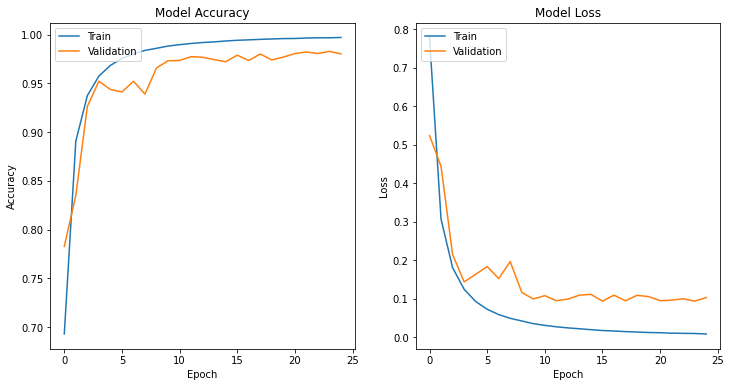

In [67]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
